In [3]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd
import dask.dataframe as dd
import datetime

# Optional Matplotlib features
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize # Needed for normalize colors
from matplotlib.cm import ScalarMappable # Needed for color maps

### Spatial-temporal Distributions of High Volume For-Hire Vehicles (Rideshare Fleet)

**Data Source**
- TLC Trip Record Data: 2022 High Volume FHV Trip Records [https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page]
- NYC Open Data: TLC Taxi Zone

**Data Description**
- hvfhs_license_num: The TLC license number of the HVFHS base or business 
    - HV0002=Juno
    - HV0003=Uber
    - HV0004=Via
    - HV0005=Lyft
- pickup_datetime: The date and time of the trip pick-up
- dropoff_datetime: The date and time of the trip drop-off
- PUlocationID: TLC Taxi Zone in which the trip began
- DOLocationID: TLC Taxi Zone in which the trip ended
- trip_miles: total miles for passenger trip
- trip_time:total time in seconds for passenger trip
- wav_match_flag: Did the trip occur in a wheelchair-accessible vehicle (WAV)?

**About Dask Library**
- a Dask dataframe consists of multiple smaller pandas dataframes which are stored in disk/cluster as a single dask object
- Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed.

**Dynamic Maps**
- Reference: https://medium.com/@necheverry_20468/exploring-dynamic-maps-with-python-a-practical-guide-b0664bb4469c

In [2]:
df = dd.read_parquet('Data/fhvhv_tripdata_2024-01.parquet')
df = df[['hvfhs_license_num','pickup_datetime','dropoff_datetime','PULocationID','DOLocationID','trip_miles',
         'trip_time','wav_match_flag']]
df.head()

hvfhs_license_num     pickup_datetime    dropoff_datetime  PULocationID  \
0            HV0003 2024-01-01 00:28:08 2024-01-01 01:05:39           161   
1            HV0003 2024-01-01 00:12:53 2024-01-01 00:20:05           137   
2            HV0003 2024-01-01 00:23:05 2024-01-01 00:35:16            79   
3            HV0003 2024-01-01 00:41:04 2024-01-01 00:56:34           234   
4            HV0003 2024-01-01 00:57:21 2024-01-01 01:10:02           148   

   DOLocationID  trip_miles  trip_time wav_match_flag  
0           158        2.83       2251              N  
1            79        1.57        432              N  
2           186        1.98        731              N  
3           148        1.99        930              N  
4            97        2.65        761              N

In [3]:
df.dtypes

hvfhs_license_num            object
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
PULocationID                  int32
DOLocationID                  int32
trip_miles                  float64
trip_time                     int64
wav_match_flag               object
dtype: object

In [4]:
df = df[(df['pickup_datetime'].dt.year==2024) & (df['pickup_datetime'].dt.month==1)]
df = df[(df['dropoff_datetime'].dt.year==2024) & (df['dropoff_datetime'].dt.month==1)]

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dow'] = df['pickup_datetime'].dt.dayofweek
df['pickup_date'] =df['pickup_datetime'].dt.date
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_dow'] = df['dropoff_datetime'].dt.dayofweek
df['dropoff_date'] =df['dropoff_datetime'].dt.date

print(len(df))
df.head()

19657346


hvfhs_license_num     pickup_datetime    dropoff_datetime  PULocationID  \
0            HV0003 2024-01-01 00:28:08 2024-01-01 01:05:39           161   
1            HV0003 2024-01-01 00:12:53 2024-01-01 00:20:05           137   
2            HV0003 2024-01-01 00:23:05 2024-01-01 00:35:16            79   
3            HV0003 2024-01-01 00:41:04 2024-01-01 00:56:34           234   
4            HV0003 2024-01-01 00:57:21 2024-01-01 01:10:02           148   

   DOLocationID  trip_miles  trip_time wav_match_flag  pickup_hour  \
0           158        2.83       2251              N            0   
1            79        1.57        432              N            0   
2           186        1.98        731              N            0   
3           148        1.99        930              N            0   
4            97        2.65        761              N            0   

   pickup_dow pickup_date  dropoff_hour  dropoff_dow dropoff_date  
0           0  2024-01-01             1            0   2024-01-01  
1           0  2024-01-01             0            0   2024-01-01  
2           0  2024-01-01             0            0   2024-01-01  
3           0  2024-01-01             0            0   2024-01-01  
4           0  2024-01-01             1            0   2024-01-01

In [5]:
# lets drop rows where PULocation and DOLocation are not present
df = df.dropna(subset=['PULocationID', 'DOLocationID'])
# drop duplicate rows
df = df.drop_duplicates()

In [6]:
df = df[(df['trip_miles']>0) & (df['trip_time']>0)]

In [7]:
# persist operation to assign some RAM to data
df = df.persist()

In [8]:
df[['trip_miles','trip_time']].describe().compute()

trip_miles     trip_time
count  1.965404e+07  1.965404e+07
mean   4.837604e+00  1.110404e+03
std    5.694693e+00  7.720257e+02
min    2.000000e-03  1.000000e+00
25%    1.493000e+00  5.710000e+02
50%    2.830000e+00  9.120000e+02
75%    5.986000e+00  1.430000e+03
max    4.176200e+02  5.206000e+04

In [9]:
tripByHour = df[['PULocationID', 'pickup_date', 'pickup_hour']].groupby(by=['pickup_date', 'pickup_hour'])\
    .count()['PULocationID'].reset_index().compute()

In [10]:
tripByHour = tripByHour.rename(columns={'PULocationID':'pickup_count'})
tripByHour['pickup_date'] = pd.to_datetime(tripByHour['pickup_date'])
tripByHour

pickup_date  pickup_hour  pickup_count
0    2024-01-01            0         52612
1    2024-01-01            1         59441
2    2024-01-01            2         57197
3    2024-01-01            3         49157
4    2024-01-01            4         34012
..          ...          ...           ...
739  2024-01-31           19         36225
740  2024-01-31           20         34235
741  2024-01-31           21         33266
742  2024-01-31           22         31657
743  2024-01-31           23         18762

[744 rows x 3 columns]

60000 3000


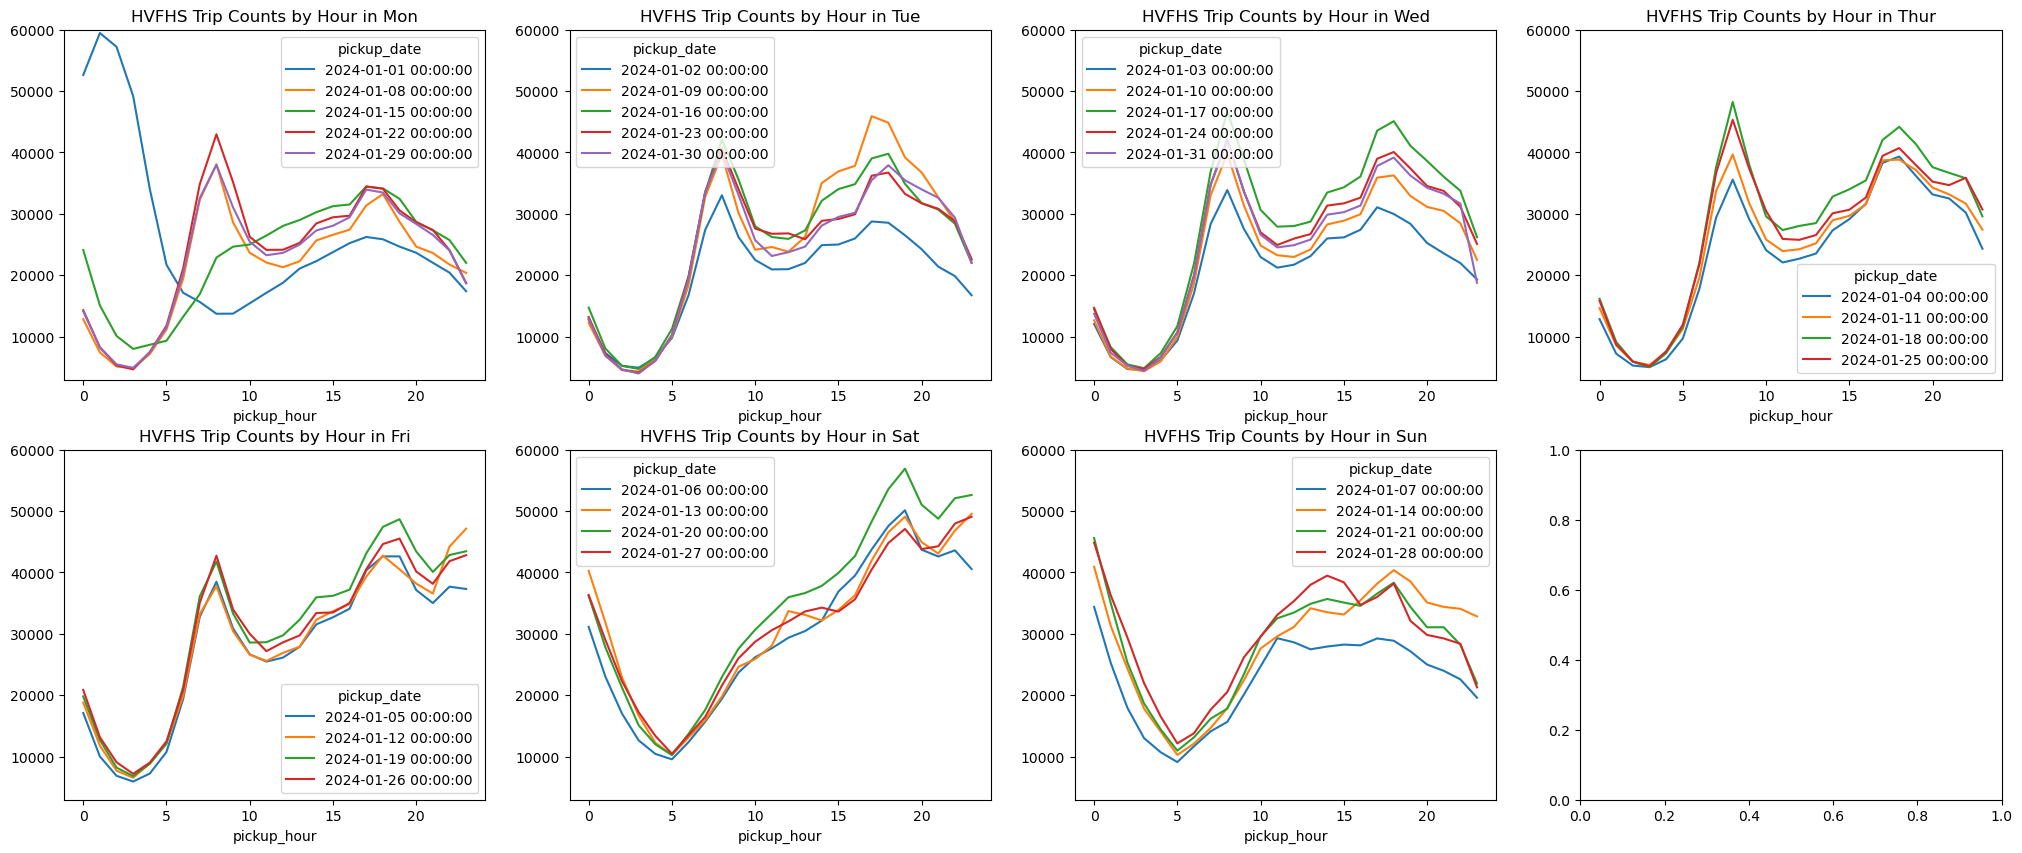

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
maxTrip = tripByHour['pickup_count'].max()
minTrip = tripByHour['pickup_count'].min()
roundMax = (round(maxTrip,-3) if round(maxTrip,-3)>=maxTrip else round(maxTrip,-3)+1000)
roundMin = (round(minTrip,-3) if round(minTrip,-3)<=minTrip else round(minTrip,-3)-1000)
print(roundMax, roundMin)

for i,dow in zip(range(7), ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']):
    row = i // 4
    col = i % 4
    df_dow = tripByHour[tripByHour['pickup_date'].dt.dayofweek==i]
    df_dow.pivot_table(values="pickup_count",index="pickup_hour",columns="pickup_date").plot(ax=axs[row,col])
    axs[row, col].set_title('HVFHS Trip Counts by Hour in {}'.format(dow))
    axs[row, col].set_ylim(roundMin, roundMax)

plt.show()

### Activity Density

In [14]:
#upload the shapefile; The 'location_i' column consists of all taxi zones within NYC + Newark airport
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi.head()

borough  location_i  objectid  shape_area  shape_leng  \
0            EWR         1.0       1.0    0.000782    0.116357   
1         Queens         2.0       2.0    0.004866    0.433470   
2          Bronx         3.0       3.0    0.000314    0.084341   
3      Manhattan         4.0       4.0    0.000112    0.043567   
4  Staten Island         5.0       5.0    0.000498    0.092146   

                      zone                                           geometry  
0           Newark Airport  POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
1              Jamaica Bay  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  Allerton/Pelham Gardens  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3            Alphabet City  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4            Arden Heights  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

In [15]:
dropoff_df = df[['DOLocationID', 'dropoff_hour','dropoff_dow','dropoff_datetime','dropoff_date']]
tripByDOWHour = dropoff_df[dropoff_df['dropoff_date'] != datetime.date(2024, 1, 1)]\
    .groupby(by=['DOLocationID', 'dropoff_hour','dropoff_dow'])\
    .count()['dropoff_datetime'].reset_index().rename(columns={'dropoff_datetime':'dropoff_count'}).compute()

In [16]:
## 24 hour activity density
dow_list = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']

def AvgActivity_by_dow(dow, density=False): 
    print('Average Activity Density in {}'.format(dow_list[dow]))
    _, ax = plt.subplots(nrows=6, ncols=4, figsize = (15, 30))
    tripByHour_Day = tripByDOWHour[tripByDOWHour['dropoff_dow']==dow]
    AvgTrip = tripByHour_Day.groupby(by=['DOLocationID','dropoff_hour']).mean()['dropoff_count'].reset_index()
    print(AvgTrip['dropoff_count'].max())

    for hr in range(24):
        row = hr // 4
        col = hr % 4
        AvgTripByHour = AvgTrip[AvgTrip['dropoff_hour']==hr]
        tripsViz = taxi.merge(AvgTripByHour, left_on='location_i', right_on='DOLocationID')
        if density:
            tripsViz['ActivityDensity'] = tripsViz['dropoff_count'] / tripsViz['shape_area']
            tripsViz.plot(ax=ax[row,col], column='ActivityDensity', legend=False)
        else:
            # tripsViz.plot(ax=ax[row,col], column='dropoff_count', legend=True)
            tripsViz.plot(ax=ax[row,col], column='dropoff_count', vmin=AvgTrip['dropoff_count'].min(), vmax=AvgTrip['dropoff_count'].quantile(0.99))
        ax[row,col].set_title('Avg Drop-off Density Activity \nfrom {}:00 to {}:59'.format(hr, hr))
        ax[row,col].xaxis.set_visible(False)
        ax[row,col].yaxis.set_visible(False)
        ax[row,col].axis('off') #'turn off' the axes lines

    plt.show()

Average Activity Density in Wed
12083.0


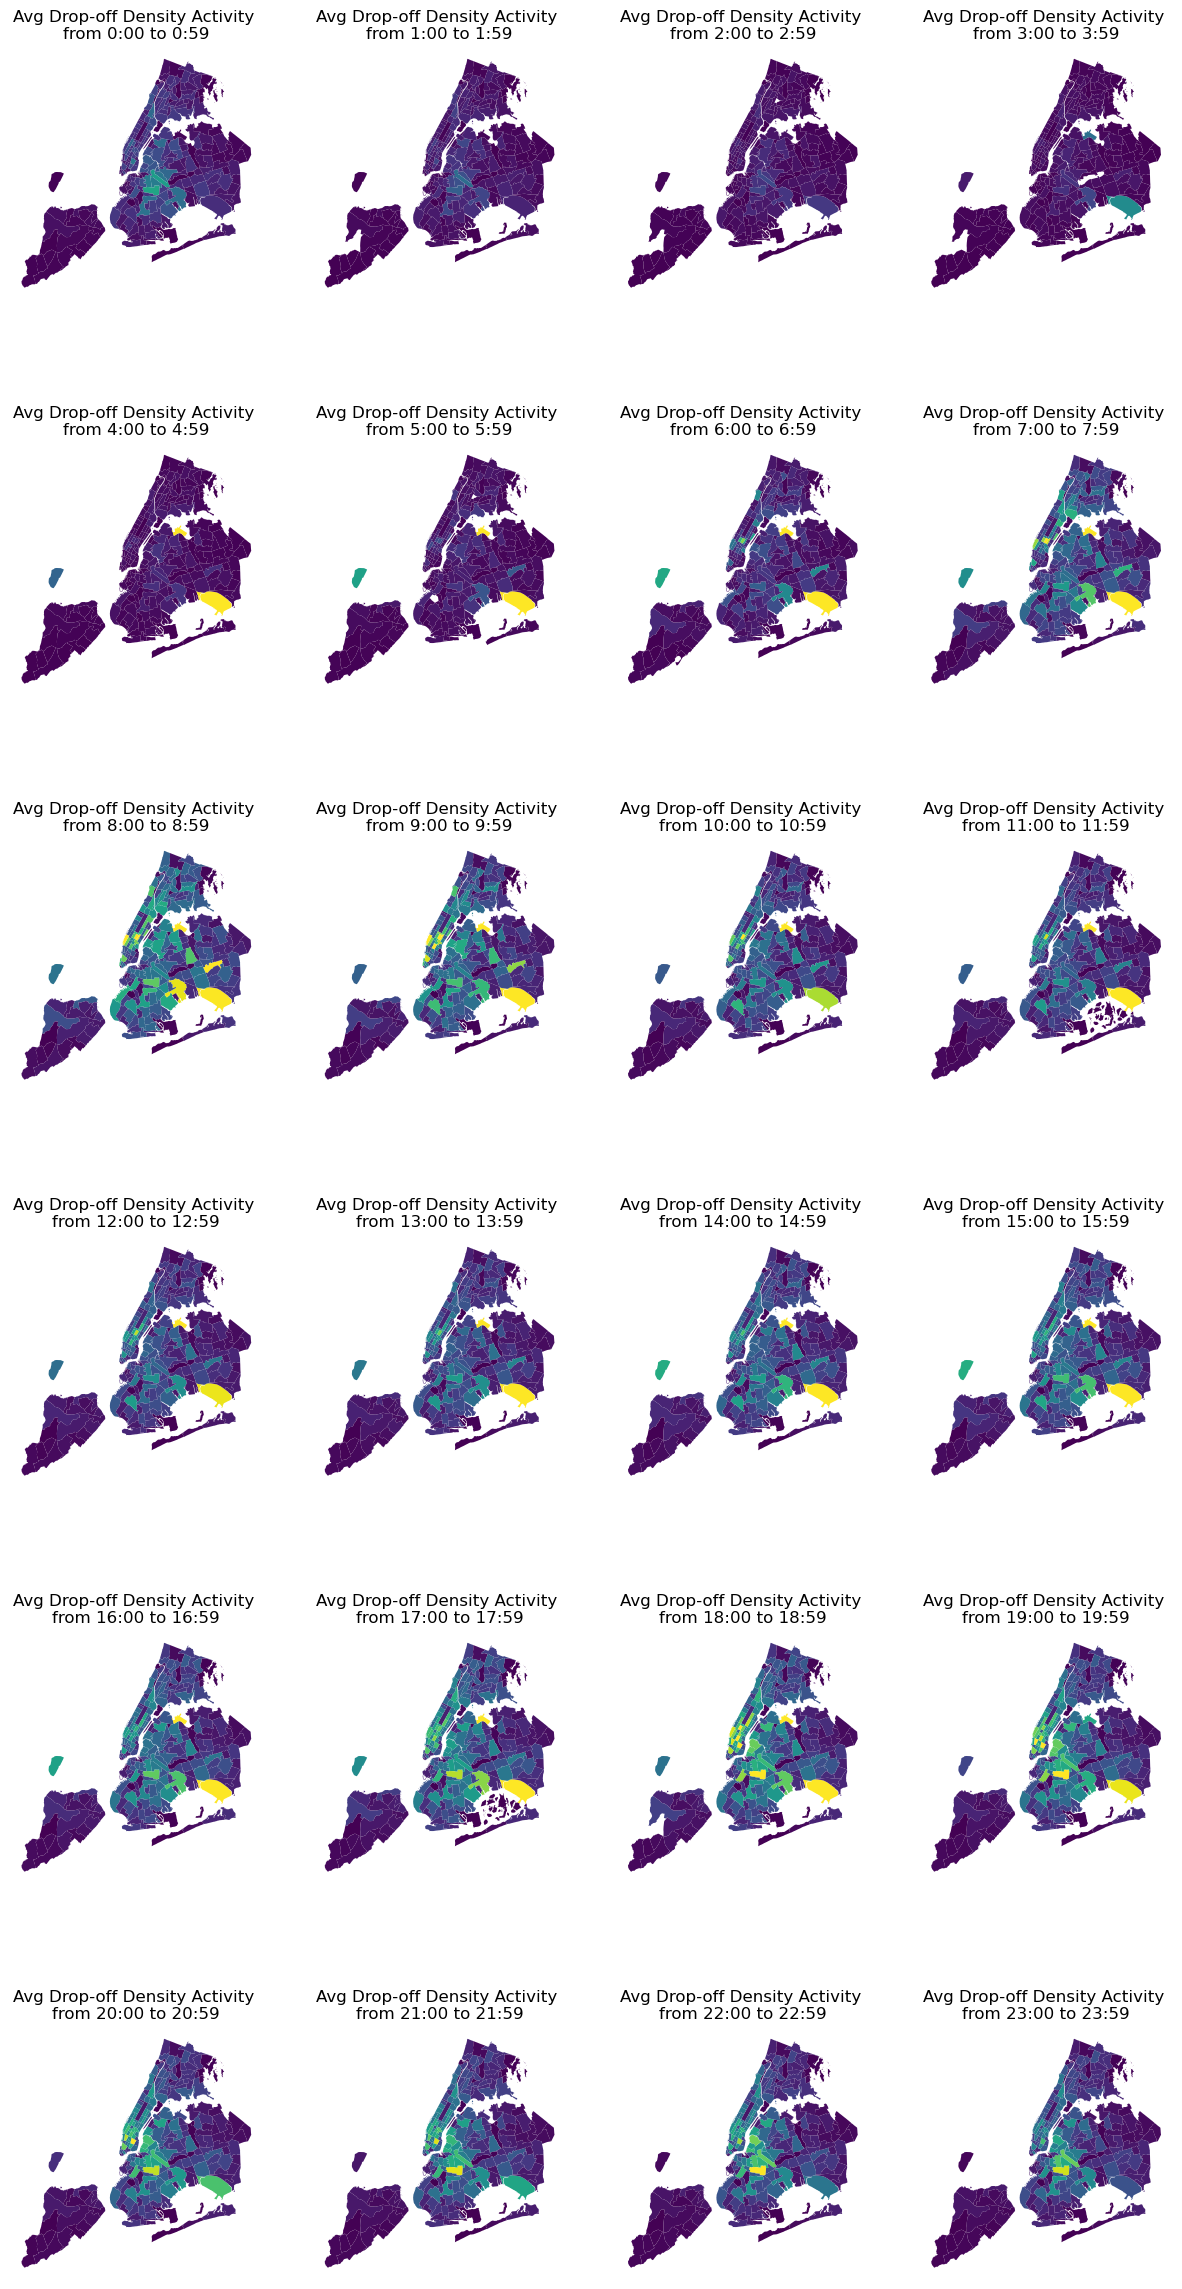

In [65]:
%matplotlib inline
AvgActivity_by_dow(2)

Average Activity Density in Sat
7466.0


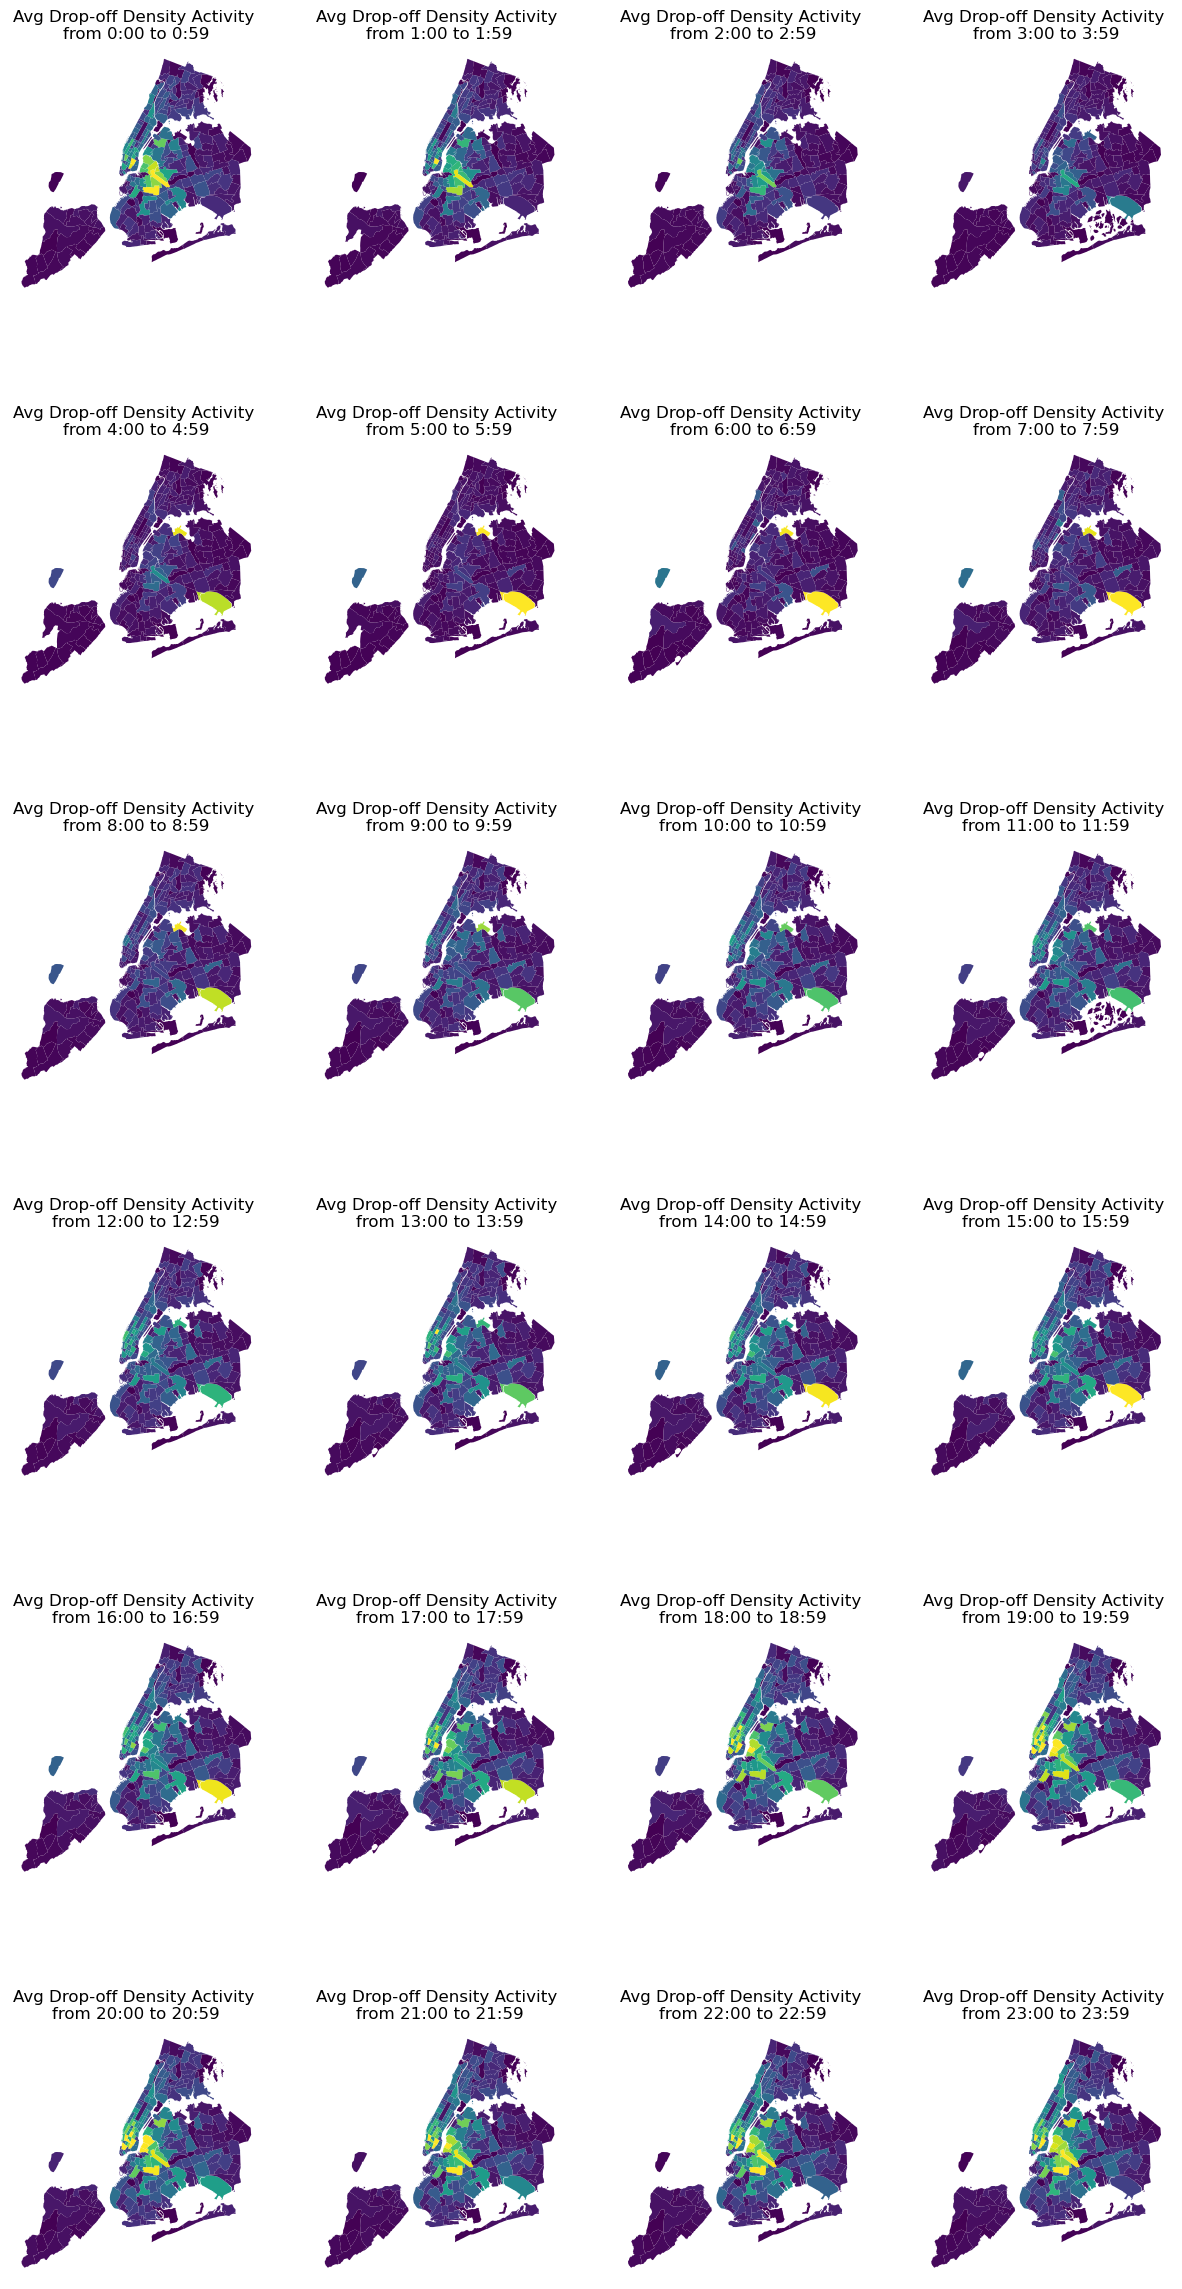

In [17]:
AvgActivity_by_dow(5)

### Dynamic Map

In [63]:
dow = 6
dayofweek = dow_list[dow]  

def init():
    taxi.plot(ax=ax, color='lightgrey', edgecolor='black') # Empty Canvas

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.set_title('', fontsize=20, pad=10)

    return ax,

def animate(hour):
    ax.clear()
    # Filter the data to the current date
    current_data = AvgTrip[AvgTrip['dropoff_hour'] == hour]

    # Add current data to empty map
    map_for_date = taxi.merge(current_data, how='left', left_on='location_i', right_on='DOLocationID')
    
    # Plot the current data
    map_for_date.plot(column='dropoff_count', linewidth=0.1, 
                    ax=ax, edgecolor='grey', legend=False, vmin=0, vmax=3000, 
                    missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    
    # Title, lines and annotations
    ax.set_title('Tracking Average Rideshare Trips Activity\n on {}'.format(dayofweek), fontsize=18, 
                    pad=5, weight='bold')

    avg_formatted = '{:,.0f}K'.format(current_data['dropoff_count'].sum()/1000)

    ax.annotate('From {}:00 to {}:59'.format(hour, hour),xy=(0.5,0), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=12, 
                    color='grey', weight='bold')
    
    ax.annotate('Source: TLC',xy=(0.9,-0.13), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=8, 
                    color='black')
    
    ax.annotate('Citywide Total Trips',xy=(0.15,0.9), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=14, 
                    color='grey', weight='bold')
    
    ax.annotate(avg_formatted,xy=(0.15,0.8), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=24, 
                    color='grey', weight='normal')
    
    # Restore axes config
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    return ax,


# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(7, 5))

# Build the color bar
norm = Normalize(vmin=0, vmax=3000)
cbar = fig.colorbar(ScalarMappable(norm=norm), ax=ax, 
                    orientation='horizontal', pad=0.05, fraction=0.046, 
                    aspect=20, shrink=0.3)

cbar.set_label('Average Count', fontsize=12)

# Creatre a list with unique hour
tripByHour_Day = tripByDOWHour[tripByDOWHour['dropoff_dow']==dow]
AvgTrip = tripByHour_Day.groupby(by=['DOLocationID','dropoff_hour']).mean()['dropoff_count'].reset_index()

hours = AvgTrip['dropoff_hour'].unique()

# Execute the animation
ani = FuncAnimation(fig, animate, frames=hours, init_func=init, blit=True)
ani.save('avg_rideshare_dow_{}.gif'.format(dow), writer='pillow', fps=8, dpi=300)

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

## Acitve Driver TLC